# Automatsko određivanje sezonskih paleta boja na osnovu analize slika lica

Cilj projekta je razviti model koji na osnovu fotografije lica može da odredi 
**sezonski tip osobe** - proleće, leto, jesen ili zima.

Sezonski tipovi se određuju na osnovu:
- **Boje kože** (topli/hladni tonovi, rumenilo)
- **Boje kose** (plava, smeđa, crna, riđa)
- **Boje očiju** (plave, zelene, smeđe)

U okviru prve kontrolne tačke biće prikazana:
- **Analiza strukture podataka** (broj slika po klasama i skupovima)
- **Vizuelizacija primera** iz svake klase
- **Izdvajanje regiona lica** (koža, kosa, oči) pomoću MediaPipe-a
- **Osnovna analiza boja** po sezonama

## Autori
[ Nataša Radmilović, Katarina Petrović ]


## Potrebne biblioteke

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

import sys
sys.path.append(os.path.join(os.getcwd(), 'src'))
from face_extractor import FaceExtractor

print("Sve biblioteke učitane")

Sve biblioteke učitane


## Priprema podataka i analiza broja slika po klasama

Pre nego što je moglo da počne treniranje modela, urađena je sledeća priprema:

1. **Ručno sakupljanje slika** - Prikupljeno je ~100 slika po sezoni
2. **Ručno označavanje** - Za svaku sliku je na osnovu lične procene određen sezonski tip
3. **Ručno cropovanje** - Slike su isečene tako da lice bude centrirano
4. **Resize** - Sve slike su svedene na dimenziju 224x224 piksela
5. **Podela na skupove** - 70% train, 15% val, 15% test (po 15 slika u val/test)

Ukupno je prikupljeno **~400 slika** (100 po sezoni), ravnomerno raspoređenih

STATISTIKA DATASET-A
split sezona  broj_slika
train spring          70
train summer          70
train autumn          70
train winter          70
  val spring          15
  val summer          15
  val autumn          15
  val winter          15
 test spring          15
 test summer          15
 test autumn          15
 test winter          15

Ukupan broj slika: 400
Prosečno slika po sezoni: 100

Ukupno po splitovima:
  train: 280 slika
  val: 60 slika
  test: 60 slika

Balansiranost klasa:
  spring: 100 slika
  summer: 100 slika
  autumn: 100 slika
  winter: 100 slika


<Figure size 1200x600 with 0 Axes>

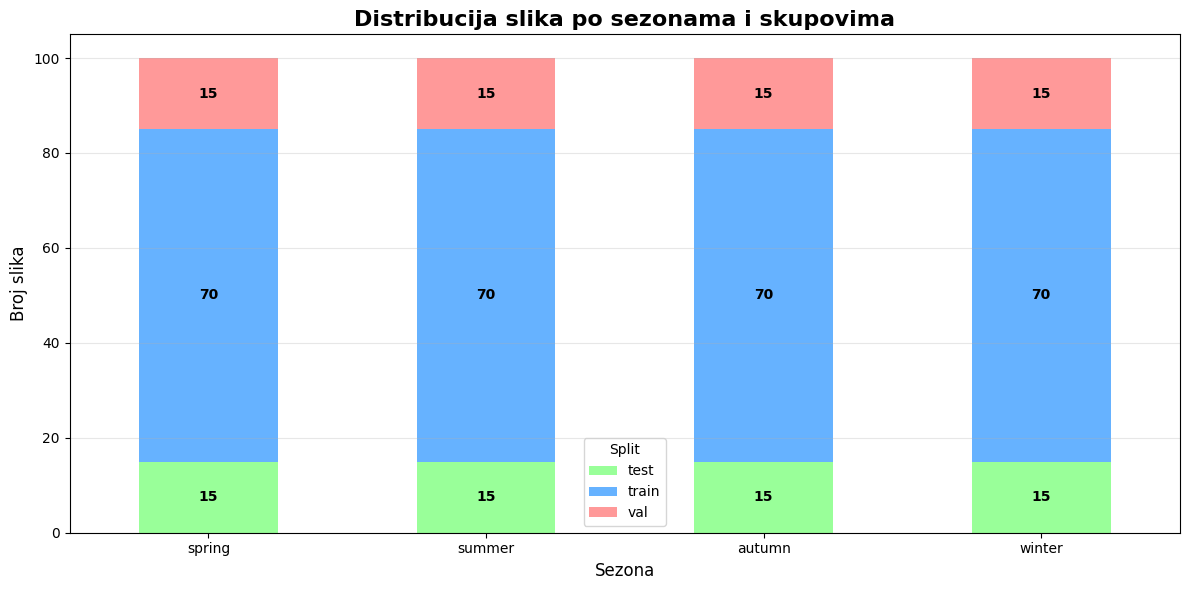

In [5]:
sezone = ['spring', 'summer', 'autumn', 'winter']
splits = ['train', 'val', 'test']

statistika = []
for split in splits:
    for sezona in sezone:
        path = f"data/{split}/{sezona}"
        if os.path.exists(path):
            broj = len(os.listdir(path))
            statistika.append({
                'split': split, 
                'sezona': sezona, 
                'broj_slika': broj
            })

df = pd.DataFrame(statistika)
print("STATISTIKA DATASET-A")
print("="*50)
print(df.to_string(index=False))
print("="*50)


ukupno = df['broj_slika'].sum()
print(f"\nUkupan broj slika: {ukupno}")


prosek_po_sezoni = df.groupby('sezona')['broj_slika'].sum().mean()
print(f"Prosečno slika po sezoni: {prosek_po_sezoni:.0f}")

print("\nUkupno po splitovima:")
for split in splits:
    ukupno_split = df[df['split'] == split]['broj_slika'].sum()
    print(f"  {split}: {ukupno_split} slika")

print("\nBalansiranost klasa:")
for sezona in sezone:
    ukupno_sezona = df[df['sezona'] == sezona]['broj_slika'].sum()
    print(f"  {sezona}: {ukupno_sezona} slika")

plt.figure(figsize=(12, 6))

pivot_df = df.pivot(index='sezona', columns='split', values='broj_slika')

pivot_df = pivot_df.reindex(['spring', 'summer', 'autumn', 'winter'])

colors = {'train': '#66B2FF', 'val': '#FF9999', 'test': '#99FF99'}
pivot_df.plot(kind='bar', stacked=True, color=[colors[c] for c in pivot_df.columns], figsize=(12, 6))

plt.title('Distribucija slika po sezonama i skupovima', fontsize=16, fontweight='bold')
plt.xlabel('Sezona', fontsize=12)
plt.ylabel('Broj slika', fontsize=12)
plt.legend(title='Split')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)


for i, sezona in enumerate(pivot_df.index):
    cumulative = 0
    for split in pivot_df.columns:
        value = pivot_df.loc[sezona, split]
        plt.text(i, cumulative + value/2, str(value), 
                ha='center', va='center', fontweight='bold')
        cumulative += value

plt.tight_layout()
plt.show()

## Primeri slika iz svake sezone

S obzirom da ne postoje gotove oznake, svaka slika je ručno klasifikovana na osnovu dosadašnjeg iskustva, pročitane literature i ličnog osećaja. Neke karakterisitike koje su se gledale i na osnovu kojih je moguće odrediti godišnje doba su:

🌸 **Proleće** – rumenija koža, svetlija kosa i svetlije oči  
☀️ **Leto** – bleda koža, svetle oči, ponekad pepeljasta kosa  
🍂 **Jesen** – žućkast ten, često crvenkasta ili riđa kosa  
❄️ **Zima** – tamnija koža, tamna kosa i tamne oči  


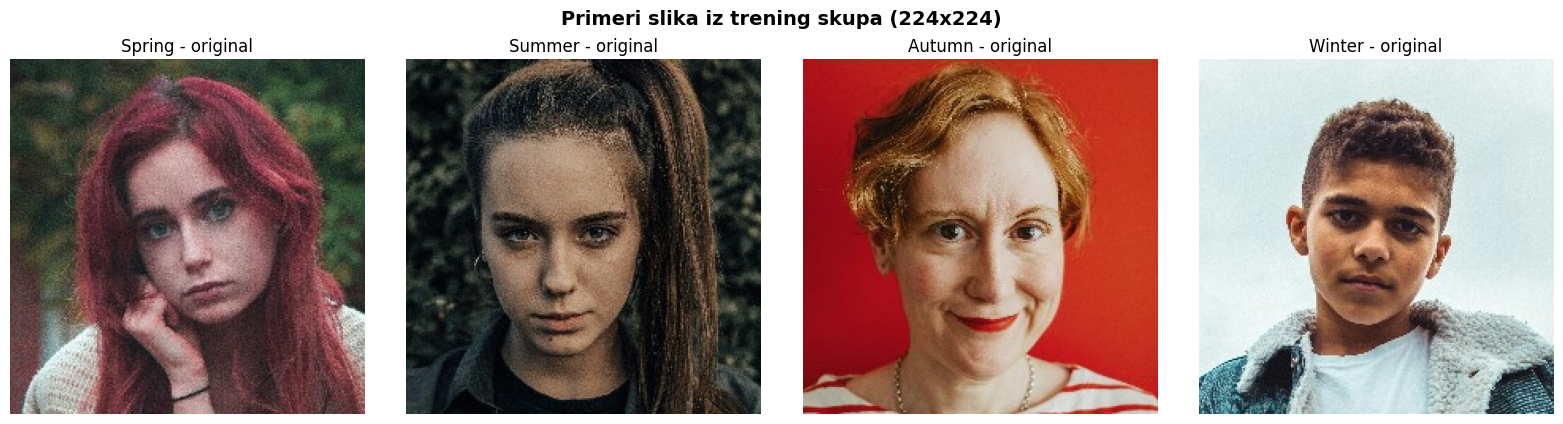

In [6]:
plt.figure(figsize=(16, 8))

for i, sezona in enumerate(['spring', 'summer', 'autumn', 'winter']):

    train_path = f"data/train/{sezona}"
    if os.path.exists(train_path) and len(os.listdir(train_path)) > 0:
        img_name = os.listdir(train_path)[0]
        img_path = f"{train_path}/{img_name}"
        
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(2, 4, i+1)
        plt.imshow(img_rgb)
        plt.title(f'{sezona.capitalize()} - original', fontsize=12)
        plt.axis('off')
        

plt.suptitle('Primeri slika iz trening skupa (224x224)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## FaceExtractor - Izdvajanje regiona lica

Za potrebe projekta razvijena je klasa `FaceExtractor` koja koristi **MediaPipe Face Mesh** za detekciju 468 ključnih tačaka na licu. Na osnovu ovih tačaka izdvajaju se regioni:

- **Koža lica** - formiranjem ovala lica i uklanjanjem očiju i usana
- **Oči** - pojedinačno levo i desno oko
- **Kosa** - procena regiona iznad čela

### Performanse izdvajanja
- **Koža i oči** - izdvajaju se vrlo precizno
- **Kosa** - izdvajanje je slabije i predstavlja izazov (varijacije u frizurama, bojama, pozadini)

Izdvojeni regioni će se koristiti za treniranje CNN modela kako bi se ispitalo da li specijalizovani regioni (koža, kosa, oči) mogu poboljšati klasifikaciju sezonskih tipova u odnosu na modele trenirane na celoj slici.

W0000 00:00:1772218262.269293   13266 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1772218262.283875   13269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1772218262.303747   13277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


FaceExtractor kreiran
 Lice detektovano
   - Piksela kože: 4604
   - Piksela kose: 1228
   - Levo oko: (20, 29, 3)
   - Desno oko: (19, 28, 3)


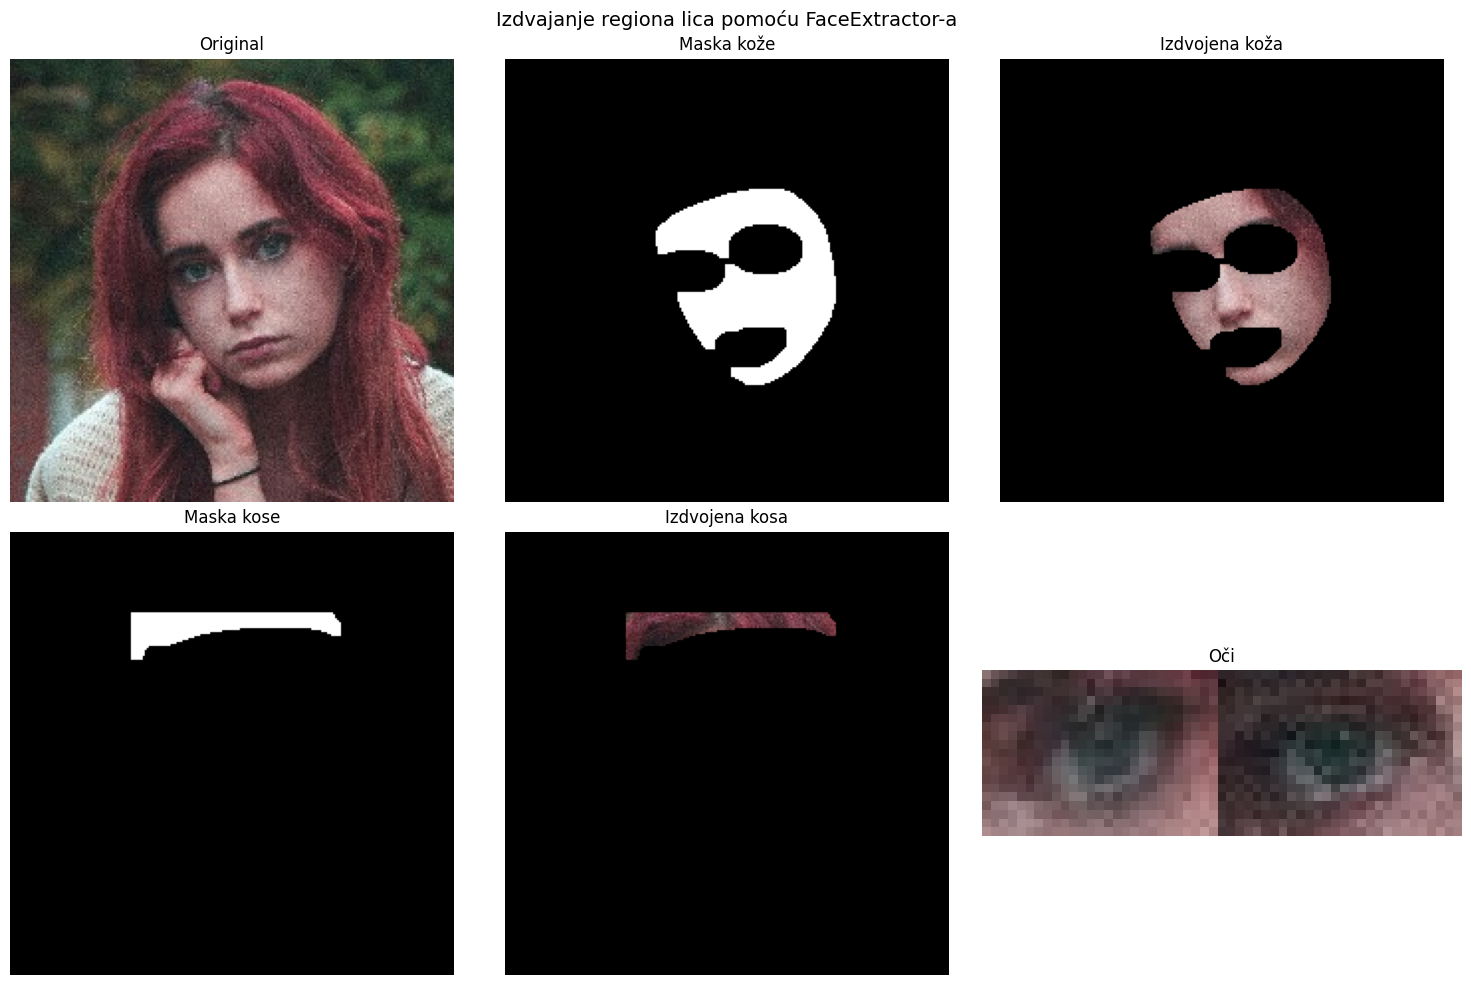

In [13]:
extractor = FaceExtractor()
print("FaceExtractor kreiran")

test_path = "data/train/spring/" + os.listdir("data/train/spring")[0]
result = extractor.extract_features(test_path, visualize=False)

if result:
    print(f" Lice detektovano")
    print(f"   - Piksela kože: {len(result['skin_pixels'])}")
    print(f"   - Piksela kose: {len(result['hair_pixels'])}")
    print(f"   - Levo oko: {result['left_eye'].shape}")
    print(f"   - Desno oko: {result['right_eye'].shape}")
    
if result:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    

    axes[0, 0].imshow(cv2.cvtColor(result['original_image'], cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')
    
   
    axes[0, 1].imshow(result['skin_mask'], cmap='gray')
    axes[0, 1].set_title('Maska kože')
    axes[0, 1].axis('off')
    
   
    skin_only = cv2.bitwise_and(result['original_image'], result['original_image'], mask=result['skin_mask'])
    axes[0, 2].imshow(cv2.cvtColor(skin_only, cv2.COLOR_BGR2RGB))
    axes[0, 2].set_title('Izdvojena koža')
    axes[0, 2].axis('off')
    
  
    axes[1, 0].imshow(result['hair_mask'], cmap='gray')
    axes[1, 0].set_title('Maska kose')
    axes[1, 0].axis('off')
    
    
    hair_only = cv2.bitwise_and(result['original_image'], result['original_image'], mask=result['hair_mask'])
    axes[1, 1].imshow(cv2.cvtColor(hair_only, cv2.COLOR_BGR2RGB))
    axes[1, 1].set_title('Izdvojena kosa')
    axes[1, 1].axis('off')
    
   
    if result['left_eye'].size > 0 and result['right_eye'].size > 0:
        left = result['left_eye']
        right = result['right_eye']

        
        target_h = min(left.shape[0], right.shape[0])
        if left.shape[0] != target_h:
            new_w = int(left.shape[1] * target_h / left.shape[0])
            left = cv2.resize(left, (new_w, target_h))
        if right.shape[0] != target_h:
            new_w = int(right.shape[1] * target_h / right.shape[0])
            right = cv2.resize(right, (new_w, target_h))

        combined_eyes = np.hstack([left, right])
        axes[1, 2].imshow(cv2.cvtColor(combined_eyes, cv2.COLOR_BGR2RGB))
        axes[1, 2].set_title('Oči')
        axes[1, 2].axis('off')
    
    plt.suptitle('Izdvajanje regiona lica pomoću FaceExtractor-a', fontsize=14)
    plt.tight_layout()
    plt.show()